#以下尚未處理
input: "data"    input_shape {1, 3, 227, 227}
input: "rois_h"  input_shape {1, 5} # changed num ROIs, [batch ind, x1, y1, x2, y2] zero-based indexing
input: "rois_o"  input_shape {1, 5} # changed num ROIs, [batch ind, x1, y1, x2, y2] zero-based indexing
input: "data_p"  input_shape {1, 2, 64, 64}
input: "score_o" input_shape {1, 1}

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input, concatenate, Add
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.engine.topology import Layer
from keras.preprocessing import image
import keras.optimizers
from sklearn.utils import shuffle
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import tensorflow as tf

from scipy.misc import imresize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from pathlib import Path

# run 這行可以讓等等 array print 出來是完整而沒有省略
# np.set_printoptions(threshold=np.inf)

Using TensorFlow backend.


In [2]:
home = str(Path.home())
data_path =home + '/projectdata/cht01/hico_20160224_det'

# Custom layer

## ROI Pooling layer

In [3]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    # Arguments
        pool_size: nxn region.
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(batch_size, image_height, image_width, image_channels)`
        X_roi:
        `(batch_size, 4)` list of rois, with ordering (y1, x1, y2, x2)
    # Output shape
        3D tensor with shape:
        `(batch_size, pool_size, pool_size, channels)`
    '''
    #参数定义
    def __init__(self, pool_size, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_size = pool_size
#         self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]
            
        super(RoiPoolingConv, self).build(input_shape)  # Be sure to call this somewhere!

    def compute_output_shape(self, input_shape):
        return None, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):
        assert(len(x) == 2) # input is a list with 2 elements

        imgs = x[0]
        boxs = x[1]
        box_inds = tf.range(0, tf.shape(imgs)[0], delta=1) # create list [0, 1, ..., batch_size - 1]
        
        '''
        tf.image.crop_and_resize
        image : [batch_size, image_height, image_width, depth]
        boxes : [num_boxes, y1, x1, y2, x2]
        box_ind : [batch_size], image for i-th box
        '''
        # image 
        proc_imgs = tf.image.crop_and_resize(image=imgs, 
                                             boxes=boxs, 
                                             crop_size=[self.pool_size, self.pool_size], 
                                             box_ind=box_inds)
        
        return proc_imgs

#     def get_config(self):
#         config = {'pool_size': self.pool_size,
#                   'num_rois':  self.num_rois}
#         base_config = super(RoiPoolingConv, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

## Test RoI pooling layer

In [4]:
inputs_1 = Input(shape=(227,227,3)) 
inputs_2 = Input(shape=(4,))
roi_pool = RoiPoolingConv(100)([inputs_1, inputs_2])

In [5]:
model = Model(inputs=[inputs_1, inputs_2], outputs=[roi_pool])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
roi_pooling_conv_1 (RoiPoolingC (None, 100, 100, 3)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
img_path = data_path + '/images/train2015/' + 'HICO_train2015_00000001.jpg'
img = image.load_img(img_path, target_size=(227, 227, 3))
img_arr1 = image.img_to_array(img)

img_path = data_path + '/images/train2015/' + 'HICO_train2015_00000001.jpg'
img = image.load_img(img_path, target_size=(227, 227, 3))
img_arr2 = image.img_to_array(img)
input_img = np.array([img_arr1, img_arr2])
input_img.shape

(2, 227, 227, 3)

In [7]:
input_roi = np.array([[0,0,0.5,0.5],
                      [0.5,0.5,1,1]], dtype=np.float32)

print(input_roi)
print(input_roi.shape)

[[ 0.   0.   0.5  0.5]
 [ 0.5  0.5  1.   1. ]]
(2, 4)


In [8]:
cropped = model.predict([input_img, input_roi])

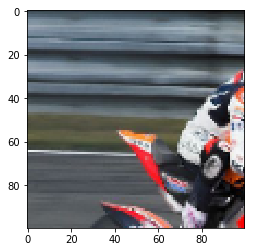

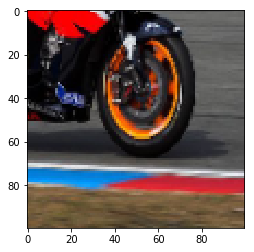

In [9]:
plt.imshow(cropped[0].astype(np.uint8))
plt.show()

plt.imshow(cropped[1].astype(np.uint8))
plt.show()

## LRN layer

In [10]:
class LRN(Layer):
    def __init__(self, n=5, alpha=0.0001, beta=0.75, k=2, **kwargs):
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.k = k
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        if K.image_dim_ordering == "th":
            _, f, r, c = self.shape
        else:
            _, r, c, f = self.shape
        half_n = self.n // 2
        squared = K.square(x)

        pooled = K.pool2d(squared, (half_n, half_n), strides=(1, 1),padding="same",pool_mode="avg")
        if K.image_dim_ordering == "th":
            summed = K.sum(pooled, axis=1, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=1)
        else:
            summed = K.sum(pooled, axis=3, keepdims=True)
            averaged = (self.alpha / self.n) * K.repeat_elements(summed, f, axis=3)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom
    
    def get_output_shape_for(self, input_shape):
        return input_shape

# pairwise data with / without padding

In [11]:
"""
Input:
box1: 4 np array with coordinates representing the first box {x11, y11, x12, y12}
box2: 4 np array with coordinates representing the second box {x21, y21, x22, y22}
length: scaling factor
        
Returns:
3D np array (2 x length x length), with the first dimension representing the filter 
on human, and the second dimension representing the filter on object 
"""

def get_map_n_pad(box1, box2, length):

    # get minimum x, y
    x_min = min(box1[0], box2[0])
    y_min = min(box1[1], box2[1])
    # translate
    bx1 = np.array([box1[0] - x_min, box1[1] - y_min,
                    box1[2] - x_min, box1[3] - y_min], dtype=np.float32)
    bx2 = np.array([box2[0] - x_min, box2[1] - y_min,
                    box2[2] - x_min, box2[3] - y_min], dtype=np.float32)
    # get new width and height
    w = max(bx1[2], bx2[2]) - min(bx1[0], bx2[0])
    h = max(bx1[3], bx2[3]) - min(bx1[1], bx2[1])
    # scale
    factor_w = np.float(length) / np.float(w)
    factor_h = np.float(length) / np.float(h)
    bx1_rs = np.array([bx1[0] * factor_w, bx1[1] * factor_h,
                       bx1[2] * factor_w, bx1[3] * factor_h])
    bx2_rs = np.array([bx2[0] * factor_w, bx2[1] * factor_h,
                       bx2[2] * factor_w, bx2[3] * factor_h])

    # generate map
    map_1 = np.zeros([length, length], dtype=np.uint8)
    map_2 = np.zeros([length, length], dtype=np.uint8)
    for i in range(int(round(bx1_rs[1])), int(round(bx1_rs[3]))):
        for j in range(int(round(bx1_rs[0])), int(round(bx1_rs[2]))):
            map_1[i][j] = 1
    for i in range(int(round(bx2_rs[1])), int(round(bx2_rs[3]))):
        for j in range(int(round(bx2_rs[0])), int(round(bx2_rs[2]))):
            map_2[i][j] = 1
    return np.array([map_1, map_2]), bx1_rs, bx2_rs

def get_map_w_pad(box1, box2, length):

    # get minimum x, y
    x_min = min(box1[0], box2[0])
    y_min = min(box1[1], box2[1])
    
    # translate
    bx1 = np.array([box1[0] - x_min, box1[1] - y_min,
                    box1[2] - x_min, box1[3] - y_min], dtype=np.float32)
    bx2 = np.array([box2[0] - x_min, box2[1] - y_min,
                    box2[2] - x_min, box2[3] - y_min], dtype=np.float32)

    # get new width and height
    w = max(bx1[2], bx2[2]) - min(bx1[0], bx2[0])
    h = max(bx1[3], bx2[3]) - min(bx1[1], bx2[1])
    # scale
    if h > w:
        factor = np.float(length) / np.float(h)
        num_pad = int(round((length - factor * w) / 2.0))
        bx1_rs = np.array([bx1[0] * factor + num_pad, bx1[1] * factor,
                           bx1[2] * factor + num_pad, bx1[3] * factor])
        bx2_rs = np.array([bx2[0] * factor + num_pad, bx2[1] * factor,
                           bx2[2] * factor + num_pad, bx2[3] * factor])
    else:
        factor = np.float(length) / np.float(w)
        num_pad = int(round((length - factor * h) / 2.0))
        bx1_rs = np.array([bx1[0] * factor, bx1[1] * factor + num_pad,
                           bx1[2] * factor, bx1[3] * factor + num_pad])
        bx2_rs = np.array([bx2[0] * factor, bx2[1] * factor + num_pad,
                           bx2[2] * factor, bx2[3] * factor + num_pad])

    # generate map
    map_1 = np.zeros([length, length], dtype=np.uint8)
    map_2 = np.zeros([length, length], dtype=np.uint8)
    for i in range(int(round(bx1_rs[1])), int(round(bx1_rs[3]))):
        for j in range(int(round(bx1_rs[0])), int(round(bx1_rs[2]))):
            map_1[i][j] = 1
    for i in range(int(round(bx2_rs[1])), int(round(bx2_rs[3]))):
        for j in range(int(round(bx2_rs[0])), int(round(bx2_rs[2]))):
            map_2[i][j] = 1
    return np.array([map_1, map_2]), bx1_rs, bx2_rs

# Load data

In [12]:
imgDir = data_path + '/images/train2015/'

img_hoi_train = pd.read_csv('img_hoi_train_new.csv',   encoding = "utf-8")
action_list   = pd.read_csv('hico_det/action_list.csv',encoding = "utf-8") 

img_hoi_train = img_hoi_train.rename(columns = {'human_bbox':'hum_bbox'})

# string -> list
img_hoi_train['rois_h'] = img_hoi_train['rois_h'].apply(lambda x: list(map(float,x.strip('[]').split(','))))
img_hoi_train['rois_o'] = img_hoi_train['rois_o'].apply(lambda x: list(map(float,x.strip('[]').split(','))))

img_hoi_train['hum_bbox'] = img_hoi_train['hum_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
img_hoi_train['obj_bbox'] = img_hoi_train['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))

# list -> array, coordinates on feature map (13*13) -> ratio (1 as denominator)
img_hoi_train['rois_h'] = img_hoi_train['rois_h'].apply(lambda x: np.asarray(x) / 13)
img_hoi_train['rois_o'] = img_hoi_train['rois_o'].apply(lambda x: np.asarray(x) / 13)

# [x1,x2,y1,y2] -> [y1,x1,y2,x2], for def ROI pooling setting, array兩層 為了input model
img_hoi_train['rois_h'] = img_hoi_train['rois_h'].apply(lambda x: [ x[2],x[0],x[3],x[1] ])
img_hoi_train['rois_o'] = img_hoi_train['rois_o'].apply(lambda x: [ x[2],x[0],x[3],x[1] ])

#img_hoi_train.to_csv('img_hoi_train_new_ROIpool.csv')

img_hoi_train['score'] = 1

In [13]:
img_hoi_train.head(2)

,Unnamed: 0,Unnamed: 0.1,action_no,hum_bbox,name,obj_bbox,rois_o,rois_h,score
0,0,0,153,"[208, 427, 33, 300]",HICO_train2015_00000001.jpg,"[59, 572, 98, 405]","[0.214442013129, 0.129102844639, 0.6328125, 0....","[0.0722100656455, 0.455142231947, 0.46875, 0.6...",1
1,1,1,154,"[213, 438, 20, 357]",HICO_train2015_00000001.jpg,"[77, 583, 115, 396]","[0.251641137856, 0.168490153173, 0.61875, 0.91...","[0.0437636761488, 0.466083150985, 0.5578125, 0...",1


In [14]:
img_hoi_train.head(2)

,Unnamed: 0,Unnamed: 0.1,action_no,hum_bbox,name,obj_bbox,rois_o,rois_h,score
0,0,0,153,"[208, 427, 33, 300]",HICO_train2015_00000001.jpg,"[59, 572, 98, 405]","[0.214442013129, 0.129102844639, 0.6328125, 0....","[0.0722100656455, 0.455142231947, 0.46875, 0.6...",1
1,1,1,154,"[213, 438, 20, 357]",HICO_train2015_00000001.jpg,"[77, 583, 115, 396]","[0.251641137856, 0.168490153173, 0.61875, 0.91...","[0.0437636761488, 0.466083150985, 0.5578125, 0...",1


In [14]:
'''
rois_o = np.array(batch['rois_o'].tolist())
rois_h = np.array(batch['rois_h'].tolist())

data_input_rois_o = np.expand_dims(rois_o, axis=1)
data_input_rois_h = np.expand_dims(rois_h, axis=1)
'''

"\nrois_o = np.array(batch['rois_o'].tolist())\nrois_h = np.array(batch['rois_h'].tolist())\n\ndata_input_rois_o = np.expand_dims(rois_o, axis=1)\ndata_input_rois_h = np.expand_dims(rois_h, axis=1)\n"

In [ ]:
'''
p_n_pads = []
p_w_pads = []
for index, row in batch.iterrows():
    hum_bbox = row['hum_bbox']
    obj_bbox = row['obj_bbox']
    
    hum_bbox_t = [hum_bbox[0], hum_bbox[2], hum_bbox[1], hum_bbox[3]]
    obj_bbox_t = [obj_bbox[0], obj_bbox[2], obj_bbox[1], obj_bbox[3]]    

    p_n_pad = get_map_n_pad(hum_bbox_t,obj_bbox_t,64)
    p_w_pad = get_map_w_pad(hum_bbox_t,obj_bbox_t,64)

    p_n_pad = p_n_pad[0]
    p_w_pad = p_w_pad[0]

    p_n_pad = p_n_pad.swapaxes(0,1)
    p_n_pad = p_n_pad.swapaxes(1,2)
    p_n_pads.append(p_n_pad)

    p_w_pad = p_w_pad.swapaxes(0,1)
    p_w_pad = p_w_pad.swapaxes(1,2)
    p_w_pads.append(p_w_pad)

    data_input_p_n_pad = np.array(p_n_pads)
    data_input_p_w_pad = np.array(p_w_pads)
'''

In [15]:
# x: img_hoi_train
# y: img_hoi_train['action_no']
# df_action = action_list[action_list['id'] == img_hoi['action_no']]

# x_batch 要做成:
# [ img, rois_h, rois_o, p_n_pad, score_o ] or
# [ img, rois_h, rois_o, p_w_pad, score_o ]

def batch_generator(x, y, pad, bs, tot_row, imgDir):
    while (True):
        
        new_ind = shuffle(range(tot_row)) # random_state=155
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        
        bat_img, bat_roi_o, bat_roi_h, bat_p_n_pad, bat_p_w_pad, bat_score_o = [],[],[],[],[],[]
        bat_label = []
        for i in range(len(x)):
            row = x.iloc[i]
            
            img = cv2.imread( imgDir + row['name'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (227,227))
            img = img / 255
            bat_img.append(img)
            
            bat_roi_h.append(row['rois_h'])
            bat_roi_o.append(row['rois_o'])
            bat_score_o.append(row['score'])
            
            bat_label.append(row['action_no'])
        
            # pairwise stream data - with padding & without padding
            hum_bbox = row['hum_bbox']
            obj_bbox = row['obj_bbox']
    
            hum_bbox_t = [hum_bbox[0], hum_bbox[2], hum_bbox[1], hum_bbox[3]]
            obj_bbox_t = [obj_bbox[0], obj_bbox[2], obj_bbox[1], obj_bbox[3]]    

            p_n_pad = get_map_n_pad(hum_bbox_t,obj_bbox_t,64)
            p_w_pad = get_map_w_pad(hum_bbox_t,obj_bbox_t,64)

            p_n_pad = p_n_pad[0]
            p_w_pad = p_w_pad[0]

            p_n_pad = p_n_pad.swapaxes(0,1)
            p_n_pad = p_n_pad.swapaxes(1,2)

            p_w_pad = p_w_pad.swapaxes(0,1)
            p_w_pad = p_w_pad.swapaxes(1,2)
            
            bat_p_n_pad.append(p_n_pad)
            bat_p_w_pad.append(p_w_pad)

      
        
            if ((i+1) % bs == 0):                
                if pad == 0:
                    x_batch = [np.array(bat_img), 
                                np.array(bat_roi_h), 
                                np.array(bat_roi_o), 
                                np.array(bat_p_n_pad), 
                                np.array(bat_score_o)]
                
                elif pad == 1:
                    x_batch = [np.array(bat_img), 
                               np.array(bat_roi_h), 
                               np.array(bat_roi_o), 
                               np.array(bat_p_w_pad), 
                               np.array(bat_score_o)]
                
                batch_action = np.eye(600)[np.array(bat_label)-1] # 600類 所以寫599 (因為取 [600] 其實是取到第601個，會有error)
                y_batch = [batch_action]
                
                bat_img, bat_roi_o, bat_roi_h, bat_p_n_pad, bat_p_w_pad, bat_score_o = [],[],[],[],[],[]
                bat_label = []
                
                yield (x_batch, y_batch) 

# Examine Image Loaded

In [17]:
# img_hoi_train = pd.read_csv('hico_det/anno_box_train.csv',encoding = "utf-8")
# action_list   = pd.read_csv('hico_det/action_list.csv',encoding = "utf-8")

# pair_bbox = []
# for i in range(10):
#     img_hoi = img_hoi_train.iloc[i]

#     input_img = cv2.imread(data_path + '/images/train2015/' + img_hoi['name'])
#     RGB_img1= cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
#     RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    
#     human_bbox =img_hoi['human_bbox'].strip('()').split(',') # 分開來 
#     human_bbox = [int(x) for x in human_bbox]                # 將字串轉成數字
    
#     cv2.rectangle(RGB_img, 
#                   (human_bbox[0], human_bbox[2]), 
#                   (human_bbox[1], human_bbox[3]), 
#                   (0,0,255), 2)
    
#     obj_bbox =img_hoi['obj_bbox'].strip('()').split(',') # 分開來 
#     obj_bbox = [int(x) for x in obj_bbox]                # 將字串轉成數字
 
#     cv2.rectangle(RGB_img, 
#                   (obj_bbox[0], obj_bbox[2]), 
#                   (obj_bbox[1], obj_bbox[3]), 
#                   (0,255,0), 2)

#     pair_bbox = list([min(human_bbox[0],obj_bbox[0]),
#                       max(human_bbox[1],obj_bbox[1]),
#                       min(human_bbox[2],obj_bbox[2]),
#                       max(human_bbox[3],obj_bbox[3])])
    
#     cv2.rectangle(RGB_img, 
#                   (pair_bbox[0], pair_bbox[2]), 
#                   (pair_bbox[1], pair_bbox[3]), 
#                   (255,0,0), 2)
   
#     h = RGB_img1[human_bbox[2]:human_bbox[3],human_bbox[0]:human_bbox[1]]
#     o = RGB_img1[obj_bbox[2]:obj_bbox[3],obj_bbox[0]:obj_bbox[1]]
#     p = RGB_img[pair_bbox[2]:pair_bbox[3],pair_bbox[0]:pair_bbox[1]]
   
#     df_action = action_list[action_list['id'] == img_hoi['action_no']]
#     fig = plt.figure(figsize=(3,3))
#     plt.title('act:{}, obj:{}'.format(df_action['verb'].iloc[0], df_action['object'].iloc[0]))
#     plt.imshow(RGB_img)
#     plt.show()


# ROI Tag

In [18]:
for i in range (len(img_hoi_train)):

    input_img = cv2.imread(data_path + '/images/train2015/' + img_hoi['name'])#     #print(rois.shape) 
    #tuple換list即可計
    img_hoi_train['ris_o'][i][0]=img_hoi_train['rois_o'][i][0]/(input_img.shape[0])*13 # *227/227相消
    img_hoi_train['rois_o'][i][1]=img_hoi_train['rois_o'][i][1]/(input_img.shape[1])*13 # *227/227相消
    img_hoi_train['rois_o'][i][2]=img_hoi_train['rois_o'][i][2]/(input_img.shape[0])*13 # *227/227相消
    img_hoi_train['rois_o'][i][3]=img_hoi_train['rois_o'][i][3]/(input_img.shape[1])*13 # *227/227相消
    
    img_hoi_train['rois_h'][i][0]=img_hoi_train['rois_h'][i][0]/(input_img.shape[0])*13 # *227/227相消
    img_hoi_train['rois_h'][i][1]=img_hoi_train['rois_h'][i][1]/(input_img.shape[1])*13 # *227/227相消
    img_hoi_train['rois_h'][i][2]=img_hoi_train['rois_h'][i][2]/(input_img.shape[0])*13 # *227/227相消
    img_hoi_train['rois_h'][i][3]=img_hoi_train['rois_h'][i][3]/(input_img.shape[1])*13 # *227/227相消

In [19]:
#img_hoi_train.to_csv("img_hoi_train_new.csv")

In [ ]:
# str to list
img_hoi_train['rois_o'] = img_hoi_train['rois_o'].apply(lambda x: list(map(float,x.strip('[]').split(','))))
img_hoi_train['rois_h'] = img_hoi_train['rois_h'].apply(lambda x: list(map(float,x.strip('[]').split(','))))
img_hoi_train['hum_bbox'] = img_hoi_train['hum_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
img_hoi_train['obj_bbox'] = img_hoi_train['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))

# Build model (CNN)

In [16]:
# caffe中在pooling時隱含了pad操作，需要在keras中補上

inputs_image = Input(shape=(227,227,3))
pad1 = ZeroPadding2D(padding=(2, 2))(inputs_image)
conv1 = Convolution2D(96, (11, 11),strides=(4, 4))(pad1)
conv1 = Activation("relu")(conv1)
#pool1 = ZeroPadding2D(padding=(2, 2))(conv1) 
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1)
norm1 = LRN()(pool1)

pad2 = ZeroPadding2D(padding=(2, 2))(norm1)
conv2 = Convolution2D(256, (5, 5))(pad2)
conv2 = Activation("relu")(conv2)
#pool2 = ZeroPadding2D(padding=(2, 2))(conv2)
pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
norm2 = LRN()(pool2)

conv3 = Convolution2D(384, (3, 3), padding="same")(norm2)
conv3 = Activation("relu")(conv3)

conv4 = Convolution2D(384, (3, 3), padding="same")(conv3)
conv4 = Activation("relu")(conv4)

conv5 = Convolution2D(256, (3, 3), padding="same")(conv4)
image_cnn_output = Activation("relu")(conv5)

/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py:636: UserWarning: Class `__main__.LRN` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


In [17]:
model = Model(inputs=[inputs_image], outputs=[image_cnn_output])
# model.summary()

# Test CNN Layer

In [18]:
img_name = img_hoi_train['name'].iloc[0] # img_hoi_train['name'].iloc[0]
img_path = data_path + '/images/train2015/' + img_name

img       = image.load_img(img_path, target_size=(227, 227, 3))
img_arr   = image.img_to_array(img)
batch_img = np.array([img_arr])

print(batch_img.shape)
print(model.predict(x=batch_img).shape)

(1, 227, 227, 3)
(1, 13, 13, 256)


# Human Stream

In [19]:
inputs_h   = Input(shape=(4,))
roi_pool_h = RoiPoolingConv(6)([image_cnn_output, inputs_h])

#flat_h = Flatten()(roi_pool_h)
gaph = GlobalAveragePooling2D()(roi_pool_h)

fc1h = Dense(4096)(gaph)
fc1h = Activation("relu")(fc1h)

fc2h = Dense(4096)(fc1h)
fc2h = Activation("relu")(fc2h)

cls_score_vo_h = Dense(600)(fc2h)

In [20]:
model = Model(inputs=[inputs_image, inputs_h], outputs=cls_score_vo_h)
# model.summary()

# Test Human Layer (做 rois_h/o for ROI pooling 之前的 test)

In [36]:
'''
rois_h = img_hoi_train['rois_h'].iloc[1]
print(rois_h)
rois_h = np.array([rois_h]) / 13
print(rois_h)
'''

[6.059080962800875, 8.896875, 0.5689277899343544, 7.2515625]
[[ 0.46608315  0.684375    0.04376368  0.5578125 ]]


In [41]:
'''
# Convert from [x1,x2,y1,y2] to [y1,x1,y2,x2]

rois_h_convt = np.zeros_like(rois_h)
rois_h_convt[:,0] = rois_h[:,2]
rois_h_convt[:,1] = rois_h[:,0]
rois_h_convt[:,2] = rois_h[:,3]
rois_h_convt[:,3] = rois_h[:,1]

print(rois_h_convt)
print(rois_h_convt.shape)
print(batch_img.shape)
'''

[[ 0.04376368  0.46608315  0.5578125   0.684375  ]]
(1, 4)
(1, 227, 227, 3)


In [21]:
batch = img_hoi_train.iloc[0:1]
rois_h = np.array(batch['rois_h'].tolist())
print(rois_h)
print(rois_h.shape)
print(batch_img.shape)

[[ 0.07221007  0.45514223  0.46875     0.6671875 ]]
(1, 4)
(1, 227, 227, 3)


In [22]:
res = model.predict(x=[batch_img, rois_h])
res.shape

(1, 600)

## Object Stream ##

In [23]:
inputs_o = Input(shape=(4,))
roi_pool_o = RoiPoolingConv(6)([image_cnn_output, inputs_o])

#flat_o = Flatten()(roi_pool_o)
gapo = GlobalAveragePooling2D()(roi_pool_o)

fc1o = Dense(4096)(gapo)
fc1o = Activation("relu")(fc1o)

fc2o = Dense(4096)(fc1o)
fc2o = Activation("relu")(fc2o)

cls_score_vo_o = Dense(600)(fc2o)

In [24]:
model = Model(inputs=[inputs_image, inputs_o], outputs=cls_score_vo_o)
# model.summary()

In [46]:
'''
# Convert from [x1,x2,y1,y2] to [y1,x1,y2,x2]

rois_o_convt = np.zeros_like(rois_o)
rois_o_convt[:,0] = rois_o[:,2]
rois_o_convt[:,1] = rois_o[:,0]
rois_o_convt[:,2] = rois_o[:,3]
rois_o_convt[:,3] = rois_o[:,1]

print(rois_o_convt.shape)
print(rois_o_convt)
'''

(1, 4)
[[ 0.25164114  0.16849015  0.61875     0.9109375 ]]


In [25]:
batch = img_hoi_train.iloc[0:1]
rois_o = np.array(batch['rois_o'].tolist())
print(rois_o.shape)
print(rois_o)

(1, 4)
[[ 0.21444201  0.12910284  0.6328125   0.89375   ]]


In [26]:
res = model.predict(x= [batch_img, rois_o])
res.shape

(1, 600)

# Pairwise Stream

In [27]:
inputs_p = Input(shape=(64,64,2))
conv1p = Convolution2D(64, (5, 5), padding="same")(inputs_p)
conv1p = Activation("relu")(conv1p)
#pool1p = ZeroPadding2D(padding=(2, 2))(conv1p) 
pool1p = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1p)

conv2p = Convolution2D(32, (5, 5), padding="same")(pool1p)
conv2p = Activation("relu")(conv2p)
pool2p = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2p)

flat_p = Flatten()(pool2p)
fc3p = Dense(256)(flat_p)
fc3p = Activation("relu")(fc3p)
cls_score_vo_p = Dense(600)(fc3p)

# Score of Object Detection

In [28]:
inputs_score_o  = Input(shape=(1,))
cls_score_so_o  = Dense(80)(inputs_score_o)
cls_score_so    = Dense(600)(inputs_score_o)

# Model Output (combine all the classification results)

In [29]:
cls_score_vo    = Add()([cls_score_vo_h, cls_score_vo_o, cls_score_vo_p])
cls_score       = Add()([cls_score_vo, cls_score_so])
cls_prob        = Activation("softmax")(cls_score)

# Prepare data for model

In [30]:
#check if model shape = input shape 
print(inputs_image.shape)    # image input
print(inputs_h.shape)        # human stream input
print(inputs_o.shape)        # object stream input
print(inputs_p.shape)        # pairwise stream input
print(inputs_score_o.shape)  # object score input
print(cls_prob.shape)        # ho rcnn output

print('=============================data=============================')

#a=(x_batch, y_batch) ，第一個[0] 是 x_batch，第二個才是 x_batch[0] 才是 [?,227,227,3]
'''
print(a[0][0].shape)
print(a[0][1].shape)
print(a[0][2].shape)
print(a[0][3].shape)
print(a[0][4].shape)
'''

(?, 227, 227, 3)
(?, 4)
(?, 4)
(?, 64, 64, 2)
(?, 1)
(?, 600)
=============================data=============================


'\nprint(a[0][0].shape)\nprint(a[0][1].shape)\nprint(a[0][2].shape)\nprint(a[0][3].shape)\nprint(a[0][4].shape)\n'

In [31]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
            return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [36]:
model = Model(inputs=[inputs_image, inputs_h, inputs_o, inputs_p, inputs_score_o], 
              outputs=[cls_prob])

# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

def top_n_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

model.compile(loss=[focal_loss(alpha=.25, gamma=2)], #loss='categorical_crossentropy'
              optimizer=opt,
              metrics=[top_n_accuracy])

In [43]:
'''
# 檢查generator 是否讓跑不動
gen = batch_generator(x_train, y_train, 1, 10, train_row)
for i in range(10):
    tmp = next(gen)
    print('----')
    for j in tmp[0]:
        print(j.shape)
'''

"\n# 檢查generator 是否讓跑不動\ngen = batch_generator(x_train, y_train, 1, 10, train_row)\nfor i in range(10):\n    tmp = next(gen)\n    print('----')\n    for j in tmp[0]:\n        print(j.shape)\n"

In [33]:
earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 若五次的training都沒有進步就會停下來

size = 0.2
x_train, x_test, y_train, y_test = train_test_split(img_hoi_train, img_hoi_train['action_no'], test_size=size, random_state=6)

train_row = int(len(img_hoi_train.index)*(1-size))
test_row  = int(len(img_hoi_train.index)*(size))

model.fit_generator(batch_generator(x_train, y_train, 1, 64, train_row, imgDir),
                    steps_per_epoch=20,
                    epochs=30,
                    validation_data=(batch_generator(x_test, y_test, 1, 10, test_row, imgDir)),
                    validation_steps=10,
                    workers=4,
                    callbacks=[earlystop]
                   )
'''
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True
'''
'''
bat = next(batch_generator(x_train, y_train, 1, 10, train_row))
model.fit(x=bat[0], y=bat[1],epochs=20)
'''

Epoch 1/30
20/20 [==============================] - 32s 2s/step - loss: 114.2818 - top_n_accuracy: 0.1820 - val_loss: 13.2575 - val_top_n_accuracy: 0.2000
Epoch 2/30
20/20 [==============================] - 30s 2s/step - loss: 82.0184 - top_n_accuracy: 0.2930 - val_loss: 12.6303 - val_top_n_accuracy: 0.3100
Epoch 3/30
20/20 [==============================] - 29s 1s/step - loss: 72.4907 - top_n_accuracy: 0.4297 - val_loss: 11.0584 - val_top_n_accuracy: 0.4300
Epoch 4/30
20/20 [==============================] - 28s 1s/step - loss: 71.9972 - top_n_accuracy: 0.4180 - val_loss: 10.1332 - val_top_n_accuracy: 0.5300
Epoch 5/30
20/20 [==============================] - 27s 1s/step - loss: 68.0657 - top_n_accuracy: 0.4766 - val_loss: 10.3542 - val_top_n_accuracy: 0.5000
Epoch 6/30
20/20 [==============================] - 26s 1s/step - loss: 66.1867 - top_n_accuracy: 0.4938 - val_loss: 10.6881 - val_top_n_accuracy: 0.4600
Epoch 7/30
20/20 [==============================] - 26s 1s/step - loss: 63.

'\nbat = next(batch_generator(x_train, y_train, 1, 10, train_row))\nmodel.fit(x=bat[0], y=bat[1],epochs=20)\n'

In [34]:
bat = next(batch_generator(x_train, y_train, 1, 10, train_row, imgDir))

pred = model.predict(bat[0])
print(bat[1][0].argmax(axis=1))
print(pred.argmax(axis=1))

print(pred[0].max())


[459 478  19 583  64 245 500 294 471 467]
[461 212  20 371  38 245 284 566 472 461]
0.123953


In [35]:
bat = next(batch_generator(x_test, y_test, 1, 10, test_row, imgDir))

pred = model.predict(bat[0])
print(bat[1][0].argmax(axis=1))
print(pred.argmax(axis=1))

print(pred[0].max())


[ 20 140 139 141 538  16 336  20 185 212]
[264 139 245 320 544  19 495 457 566 323]
0.0526035


In [36]:
bat = next(batch_generator(x_test, y_test, 1, 10, test_row, imgDir))

pred = model.predict(bat[0])
print(bat[1][0].argsort()[-3:]) # 每張圖取前3名，若要由小到大則要增加[::-1]
print(pred.argsort()[-3:])


[[  0 396 397 ..., 197 599 109]
 [  0 396 397 ..., 204 197  18]
 [  0 396 397 ..., 196 599 377]]
[[579 336 200 ...,  38 108 109]
 [564 579  24 ..., 154  18  20]
 [283  24 335 ...,  93  89 169]]


# Evaluation

In [34]:
imgDir = data_path + '/images/test2015/'

img_hoi_test  = pd.read_csv('img_hoi_test_new.csv',    encoding = "utf-8")
action_list   = pd.read_csv('hico_det/action_list.csv',encoding = "utf-8") 

img_hoi_test = img_hoi_test.rename(columns = {'human_bbox':'hum_bbox'})

# string -> list
img_hoi_test['rois_h'] = img_hoi_test['rois_h'].apply(lambda x: list(map(float,x.strip('[]').split(','))))
img_hoi_test['rois_o'] = img_hoi_test['rois_o'].apply(lambda x: list(map(float,x.strip('[]').split(','))))

img_hoi_test['hum_bbox'] = img_hoi_test['hum_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))
img_hoi_test['obj_bbox'] = img_hoi_test['obj_bbox'].apply(lambda x: list(map(int,x.strip('[]').split(','))))

# list -> array, coordinates on feature map (13*13) -> ratio (1 as denominator)
img_hoi_test['rois_h'] = img_hoi_test['rois_h'].apply(lambda x: np.asarray(x) / 13)
img_hoi_test['rois_o'] = img_hoi_test['rois_o'].apply(lambda x: np.asarray(x) / 13)

# [x1,x2,y1,y2] -> [y1,x1,y2,x2], for def ROI pooling setting, array兩層 為了input model
img_hoi_test['rois_h'] = img_hoi_test['rois_h'].apply(lambda x: [ x[2],x[0],x[3],x[1] ])
img_hoi_test['rois_o'] = img_hoi_test['rois_o'].apply(lambda x: [ x[2],x[0],x[3],x[1] ])

#img_hoi_test.to_csv('img_hoi_test_new_ROIpool.csv')

img_hoi_test['score'] = 1

In [37]:
# 總共餵 10*100 筆資料進去 predict
model.evaluate_generator(batch_generator(img_hoi_test, img_hoi_test['action_no'], 1, 334, len(img_hoi_test), imgDir),steps=100)

[329.58362640380858, 0.13047904081642628]

In [ ]:
# output 會是 model.metrics_names (loss + top_n_accuracy)
# next() 會自動作成 for loop, 吐出一個完整list，包含 (x_batch, y_batch)

# 總共餵 全部 筆數 資料進去 predict
test_data = next(batch_generator(img_hoi_test, img_hoi_test['action_no'], 1, len(img_hoi_test), len(img_hoi_test), imgDir))
x_test = test_data[0]
y_test = test_data[1]

model.evaluate(x_test, y_test, batch_size=None, verbose=0, sample_weight=None)

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 231, 231, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 96)   34944       zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 56, 56, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
# 補充
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)